In [100]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.metrics import mean_squared_error

Load data - 'minutes' encapsulates 'results', no need to look at both data sets.

In [101]:
minutes = pd.DataFrame(pd.read_csv('minutes.csv')).dropna()

Compute the number of goals scored within each minute (frequency), and plot.

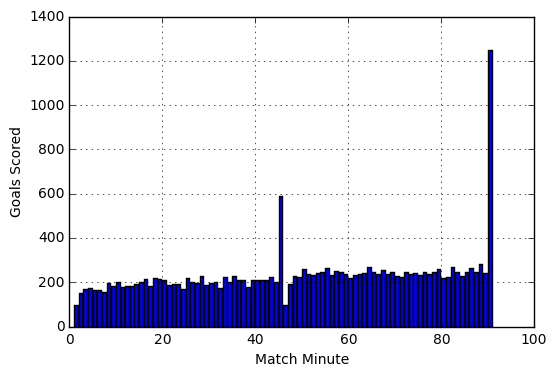

In [102]:
freq = minutes.groupby('minute')['minute'].count().reset_index(name='goals')
plt.bar(freq['minute'], freq['goals']), plt.grid()
plt.xlabel('Match Minute'), plt.ylabel('Goals Scored')
plt.show()

It's easy to spot some interesting anomalies here - i.e. minutes in which a proportionally larger number of goals are scored. The 45th minute and 90th minute are two such examples, and can perhaps be explained by the fact that any goals scored after those times (additional/injury time) are recorded as occurring in the 45th and 90th minute respectively. I remove these from my analysis as the amount of extra time is decided on a match by match basis, and so I wouldn't expect them to be comparable, at least not for such a simple analysis.

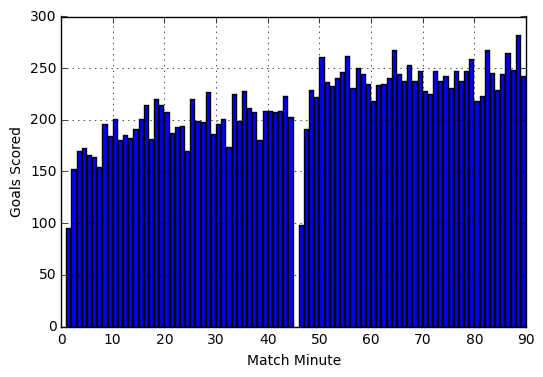

In [103]:
freq = freq[~freq['minute'].isin([45, 90])]
plt.bar(freq['minute'], freq['goals']), plt.grid()
plt.xlabel('Match Minute'), plt.ylabel('Goals Scored')
plt.show()

Having removed these two anomalies, we can see more obviously that there may indeed be some others. Namely, minute 1, and minute 46 (i.e. the minutes immediately proceeding kick-off and half-time. Intuitively, we expect this since the ball tends to be in a non-offensive position (i.e. the centre-circle), and gets passed backwards. Again, I disregard these data points for the time-being as it is not immediately obvious how to model them. In further analyses, I would want to expand on these areas in particular as (at least in my experience, without statistical reasoning!), scoring at these times can have an interesting effect on tactics and team morale, perhaps more so than at other times of the game.

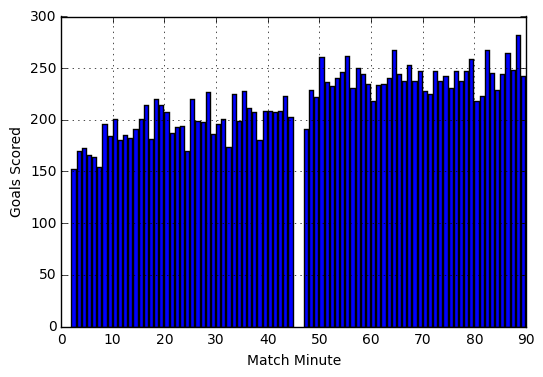

In [105]:
freq = freq[~freq['minute'].isin([1, 46])]
plt.bar(freq['minute'], freq['goals']), plt.grid()
plt.xlabel('Match Minute'), plt.ylabel('Goals Scored')
plt.show()

Here we see an interesting pattern emerging - that there is some sort of steady increase in total number of goals, as the match progresses. To see this more acutely, I compute the percentage of goals scored within each minute (excluding goals occuring in minutes 1, 45, 46, and 90. I then plot match minute versus the percentage of goals scored within each minute. 

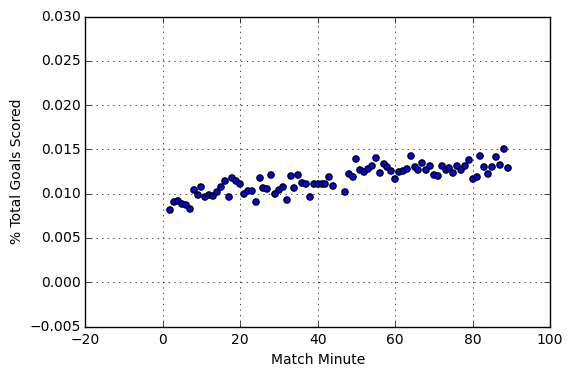

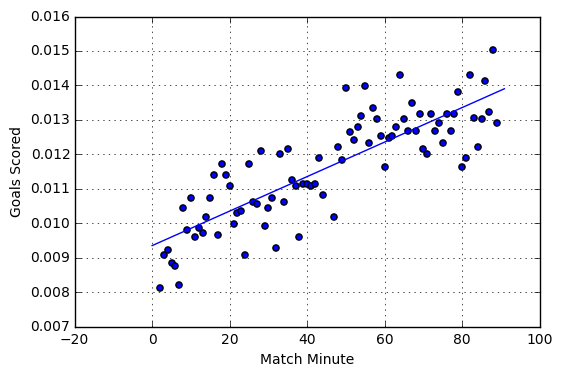

In [107]:
total_goals = sum(freq['goals'])
freq['percentPerMin'] = freq['goals'] / float(total_goals)
plt.scatter(freq['minute'], freq['percentPerMin']), plt.grid()
plt.xlabel('Match Minute'), plt.ylabel('% Total Goals Scored')
plt.show()

# Fitting a line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(freq['minute'],
                                                               freq['percentPerMin'])
line = np.arange(0, 91, 0.1)
plt.plot(line, line*slope+intercept)
plt.scatter(freq['minute'], freq['percentPerMin']), plt.grid()
plt.xlabel('Match Minute'), plt.ylabel('Goals Scored')
plt.show()

From visual inspection alone, there seems to be a relationship between the minute of the match, and the number of goals scored in that minute. The initial model assumed an average number of goals scored per minute per match based on an aggregation of all of the data. This graph suggests that the method of aggregation is too simplistic, and that there exists an evolving number of goals scored per minute, as the game goes on. My hypothesis is that there is a linear relationship between the match minute, and goals scored in that minute, and I would like to test the assumptions upon which that relationship is valid. Fitting a linear model following an ordinary least squares methodology (statsmodels library), I produce some statistics.

In [108]:
lm = smf.ols('goals ~ minute', freq[['minute', 'goals']]).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                  goals   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     193.4
Date:                Thu, 20 Apr 2017   Prob (F-statistic):           1.67e-23
Time:                        09:47:53   Log-Likelihood:                -359.98
No. Observations:                  86   AIC:                             724.0
Df Residuals:                      84   BIC:                             728.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    175.3339      3.530     49.669      0.0

The adj-R^2 value implies that a great deal of variability of response data can be explained by this single predictor. I would however, like to assess whether there is indeed a statistically significant improvement over a model that aggregates over all minutes of the match - essentially an intercept-only model.

We can test this by defining the null and alternative hypotheses for an F-test at the 5% significance level. Null: that the fit of the intercept-only model and this model are equal. Alt: that the fit of the linear model is a significant improvement over the basic model. We see that the p-value in this case is less than our 5% significance level, and so we can reject the null hypothesis that the models give an equal fit.

As there is only a single independent variable, there is no reason to check for multi-collinearity. We can however, check that our data satisfy the multivariate normal assumption using a Kolmogorov-smirnov test. In the interest of time, I continue on the basis that the skewness and kurtosis of the distribution quite closely match that of a normal distribution (skewness: 0, kurtosis: 3).

Finally, we would want to check for homoscedasticity. We can test this by determining whether there is significant variation in the residuals of the samples. Again, I am satisfied that the scatter plots show a normal level of variation - there is no obvious widening in residual values. 

Satisfied that there is evidence to suggest a linear relationship between match-minute and goals scored, we now wish to explore the generalisability of our model. 1000 random training:test splits in the proportion 70:30 are taken, and a linear model fitted. We compute the root mean squared error at each stage, and compare the mean of those results afterwards.

In [111]:
# Function to normalise data columns
def normalise(df):
    return (df - np.mean(df))/np.std(df)

# Z_score of the data (to standardise)
freq = normalise(freq)[['minute', 'goals']]

rmse_train, rmse_test = [], []
for run in range(1000):
    split = np.random.rand(len(freq)) < 0.7
    
    # Compute training and test set proportions based on random splits
    xy_train = freq[split]
    xy_test = freq[~split]
    
    # Fit a linear model on the training data
    lm = smf.ols('goals ~ minute', xy_train).fit()

    # Root mean squared error of training and test set predictions
    rmse_train.append(np.sqrt(mean_squared_error(xy_train[['goals']],
                                                 lm.predict(xy_train[['minute']]))))
    rmse_test.append(np.sqrt(mean_squared_error(xy_test['goals'],
                                                lm.predict(xy_test[['minute']]))))
    
print 'Training set RMSE: %s, Test set RMSE: %s' % (np.mean(rmse_train), np.mean(rmse_test))

Training set RMSE: 0.547999874887, Test set RMSE: 0.560234130132


I would like to explore this further using some kind of cross-validation to determine the extent to which overfitting is occurring, and how it can be counteracted.
So to answer the question, I believe there has been an improvement in our model as we have shown and proven a linear relationship between match minute and goals scored; refuting the claim that this relationship is indeed constant. Whilst I haven't considered the anomalous data points (minutes 1, 45, 46, 90), this represents a significant improvement that I expect to generalise better to unseen data, than the original. 